In [31]:
from img2table.ocr import TesseractOCR
from img2table.document import Image as Im
from matplotlib import pyplot as plt
import pytesseract
import cv2
from PIL import Image as PILImage
from IPython.display import display_html
from PIL import Image as pilimage
import numpy as np
import math

pytesseract.pytesseract.tesseract_cmd ='C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

In [47]:
#paths for differrent pictures in my dataset
src0 = 'test.jpg'
src1 = '141899.jpg'
src2 = '213950.jpg'  #тяжелый!
src = '228963.jpg'

Open CV2 image

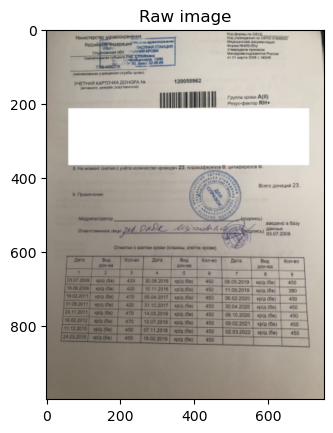

In [48]:
image = cv2.imread(src)
image = np.ascontiguousarray(image[..., [2, 1, 0]])
plt.imshow(image)
plt.title('Raw image')
plt.show()

## preprocessing

сделать предобработку например в cv2 или еще где. Потом сохранить картинку и в дальнейшем ее скармливать image2table.
Сама предобработка.

1. рисайз, чтобы все картинки были одного размера. Надо учесть еще разрешение.
2. перевод в ЧБ
5. блер (размытие) - надо?
5. Трешолд (адаптивный!) 
4. нойс ремувал 
6. скью корекшн


Не забыть потом сделать Alignment по нескольким документам, которые у нас есть.



In [49]:
# preprocessing function

def preprocess_img(path,
                   dn_h=15,  dn_templateWindowSize=7, dn_searchWindowSize=21,
                   blur_ksize=1,
                   thr_BlockSize=11,thr_c=2,
                   visualize=False):
    
    #load image
    image = cv2.imread(path)
    image = np.ascontiguousarray(image[..., [2, 1, 0]])
    
    # denoising of image
        #h: Smaller h values preserve picture details while preserving some noise,
            #while larger h values perfectly remove noise while also removing image details.
        #templateWindowSize: The template patch's size in pixels when computing weights (odd integer).
        #searchWindowSize: The window's size in pixels is what is utilized
            #to calculate the weighted average for a specific pixel (odd integer). 
        
    img_dn = cv2.fastNlMeansDenoising(image, None, dn_h, dn_templateWindowSize, dn_searchWindowSize) 
    
    #grayscale
    img_gs = cv2.cvtColor(img_dn, cv2.COLOR_BGR2GRAY)

    # median Blurring
    img_mb = cv2.medianBlur(img_gs, blur_ksize)
    
    # thresholding
        #BlockSize - It decides the size of neighbourhood area.
        #C - It is just a constant which is subtracted from the mean or weighted mean calculated.
    img_thr = cv2.adaptiveThreshold(img_mb, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,thr_BlockSize,thr_c)
    
    #visualization
    if visualize:
        imgs = [img_dn, img_gs, img_mb]
        plt.figure(figsize=(13,20))
        plt.subplot(121)
        plt.imshow(image)
        plt.axis('off')
        plt.title('raw image')
        plt.subplot(122)
        plt.imshow(img_thr, 'gray')
        plt.axis('off')
        plt.title('final image')
        plt.show()
        
        plt.figure(figsize=(20,20))
        plt.subplot(131)
        plt.imshow(img_dn, 'gray')
        plt.axis('off')
        plt.title('No-noise image')
        plt.subplot(132)
        plt.imshow(img_gs, 'gray')
        plt.axis('off')
        plt.title('Gray image')
        plt.subplot(133)
        plt.imshow(img_mb, 'gray')
        plt.title('median blur')
        plt.show()
        
    return img_thr

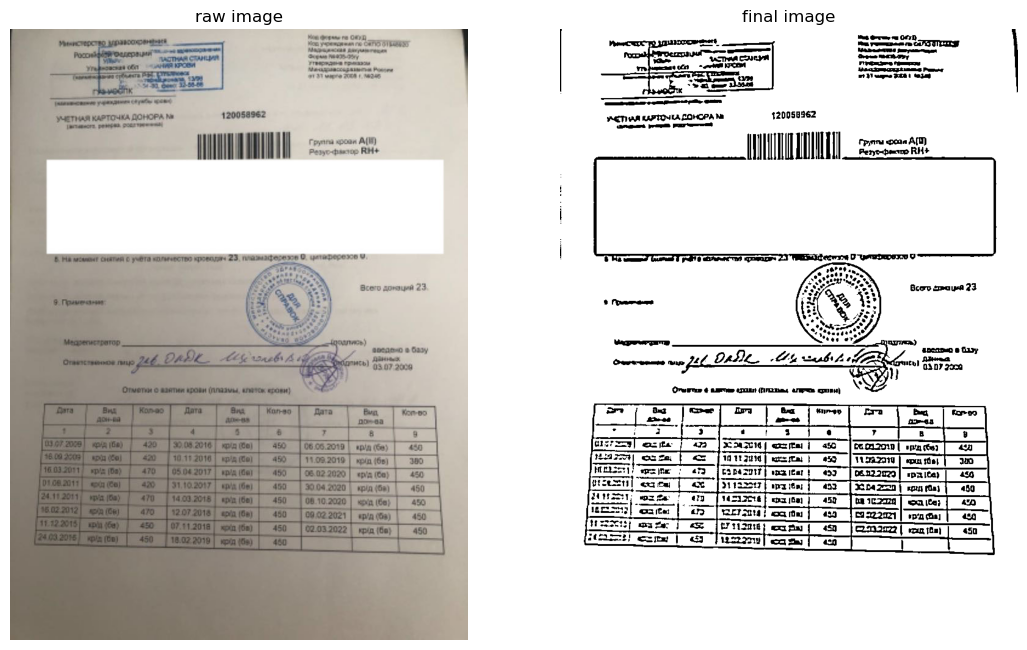

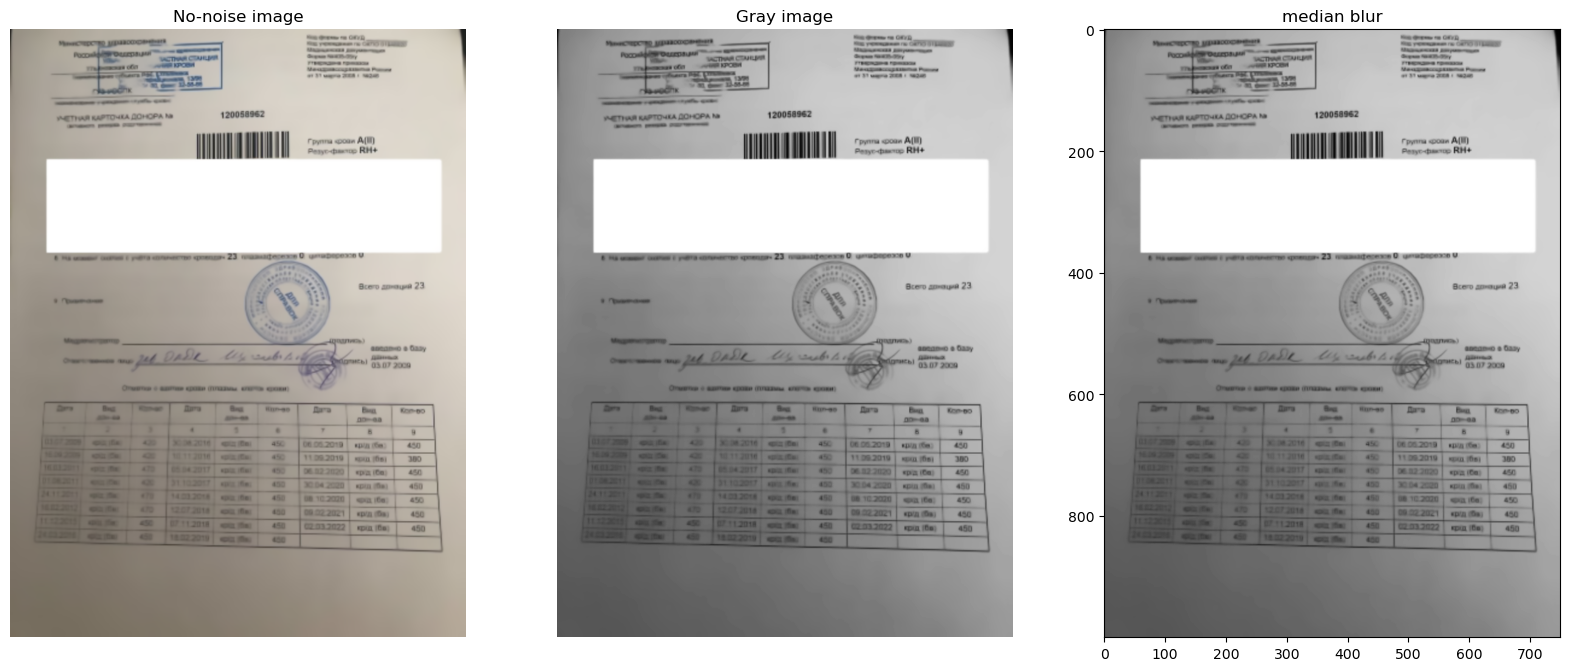

array([[  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [50]:
 preprocess_img(src, visualize=True)

saving preprocessed file

In [51]:
#save prepprocessed file
src_new = src[:-4] + '_preprocessed.jpg'
cv2.imwrite(src_new,  preprocess_img(src))

True

### Skew correction

Hough transform

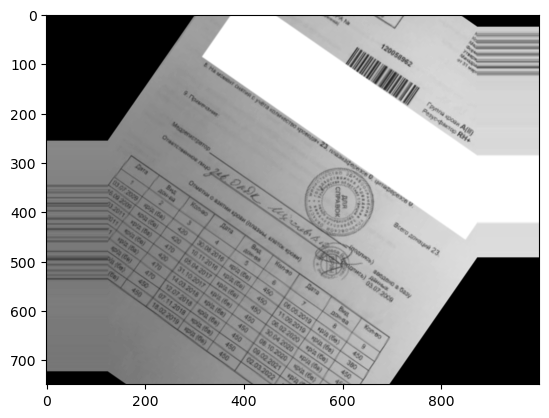

In [52]:
def compute_skew(file_name):
    
    #load in grayscale:
    src = cv2.imread(file_name,0)
    height, width = src.shape[0:2]
    
    #invert the colors of our image:
    #cv2.bitwise_not(src, src)
    
    #Hough transform:
    minLineLength = width/2.0
    maxLineGap = 20
    lines = cv2.HoughLinesP(src,1,np.pi/180,100,minLineLength,maxLineGap)
    
    #calculate the angle between each line and the horizontal line:
    angle = 0.0
    nb_lines = len(lines)
    
    
    for line in lines:
        angle += math.atan2(line[0][3]*1.0 - line[0][1]*1.0,line[0][2]*1.0 - line[0][0]*1.0);
    
    angle /= nb_lines*1.0
    
    return angle* 180.0 / np.pi


def deskew(file_name,angle):
    
    #load in grayscale:
    img = cv2.imread(file_name,0)
    
    #invert the colors of our image:
    #cv2.bitwise_not(img, img)
    
    #compute the minimum bounding box:
    non_zero_pixels = cv2.findNonZero(img)
    center, wh, theta = cv2.minAreaRect(non_zero_pixels)
    
    root_mat = cv2.getRotationMatrix2D(center, angle, 1)
    rows, cols = img.shape
    rotated = cv2.warpAffine(img, root_mat, (cols, rows), flags=cv2.INTER_CUBIC)


    #Border removing:
    sizex = np.int0(wh[0])
    sizey = np.int0(wh[1])
#    print theta
    if theta > -45 :
        temp = sizex
        sizex= sizey
        sizey= temp
    return cv2.getRectSubPix(rotated, (sizey,sizex), center)
  

file_path = 'put img path here'  
angel = compute_skew(src)
img_dsk = deskew(src,angel)
plt.imshow(img_dsk, 'gray')
plt.show()

deskew

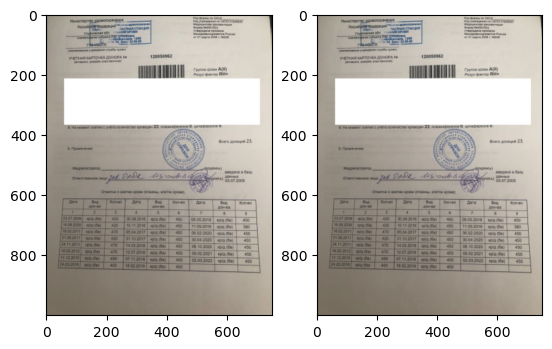

In [53]:
from skimage import io
from skimage.transform import rotate
from skimage.color import rgb2gray
from deskew import determine_skew

def deskew(_img):
    image = io.imread(_img)
    grayscale = rgb2gray(image)
    angle = determine_skew(grayscale)
    rotated = rotate(image, angle, resize=True) * 255
    return rotated.astype(np.uint8)

def display_before_after(_original):
    plt.subplot(1, 2, 1)
    plt.imshow(io.imread(_original))
    plt.subplot(1, 2, 2)
    plt.imshow(deskew(_original))

display_before_after(src)

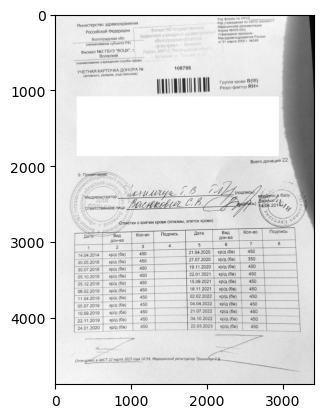

C:\Users\zhvan\AppData\Local\Temp\ipykernel_17780\858906728.py:15: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  data = inter.rotate(arr, angle, reshape=False, order=0)


Best angle: -1


C:\Users\zhvan\AppData\Local\Temp\ipykernel_17780\858906728.py:30: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  data = inter.rotate(bin_img, best_angle, reshape=False, order=0)


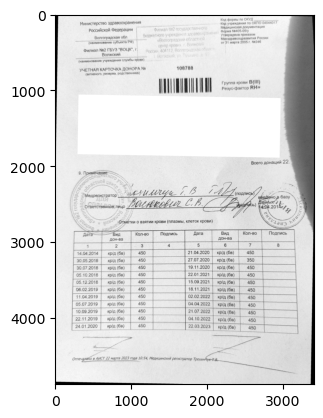

In [54]:
import sys
from PIL import Image as pilimage
from scipy.ndimage import interpolation as inter

input_file = src2
img = pilimage.open(input_file)
# convert to binary
wd, ht = img.size
pix = np.array(img.convert('1').getdata(), np.uint8)
bin_img = (pix.reshape((ht, wd)) / 255.0)
plt.imshow(bin_img, cmap='gray')
plt.show()
plt.savefig('binary.png')
def find_score(arr, angle):
    data = inter.rotate(arr, angle, reshape=False, order=0)
    hist = np.sum(data, axis=1)
    score = np.sum((hist[1:] - hist[:-1]) ** 2)
    return hist, score
delta = 1
limit = 5
angles = np.arange(-limit, limit+delta, delta)
scores = []
for angle in angles:
    hist, score = find_score(bin_img, angle)
    scores.append(score)
best_score = max(scores)
best_angle = angles[scores.index(best_score)]
print('Best angle: {}'.format(best_angle))
# correct skew
data = inter.rotate(bin_img, best_angle, reshape=False, order=0)
img_sk = pilimage.fromarray((255 * data).astype("uint8"))
plt.imshow(img_sk, cmap='gray')
plt.show()
#img.save('skew_corrected.png')

## Extracting table

In [55]:
image_processed = Im(src_new, 
              detect_rotation=True)
ocr = TesseractOCR(n_threads=1, lang="rus")

In [56]:
extracted_tables = image_processed.extract_tables(ocr=ocr,
                                      implicit_rows=False,
                                      borderless_tables=False,
                                      min_confidence=50)

In [57]:
tables = extracted_tables[0]

display_html(tables.html_repr(title=f"Extracted table"), raw=True)

#for idx, table in enumerate(tables):
#display_html(table.html_repr(title=f"Page {page + 1} - Extracted table n°{idx + 1}"), raw=True)

,0,1,2,3,4,5,6,7,8
0,,,,1911214,,,11222219,С,
1,"1,",,,,,,,,
2,ЕЕ,ЕЕ,,31152517,453,453,,,480
3,==.,==.,==.,,,,,,
4,==.,==.,==.,,,,,,
5,,,,,,451,,,
6,«52,«52,«52,,22,22,,,


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


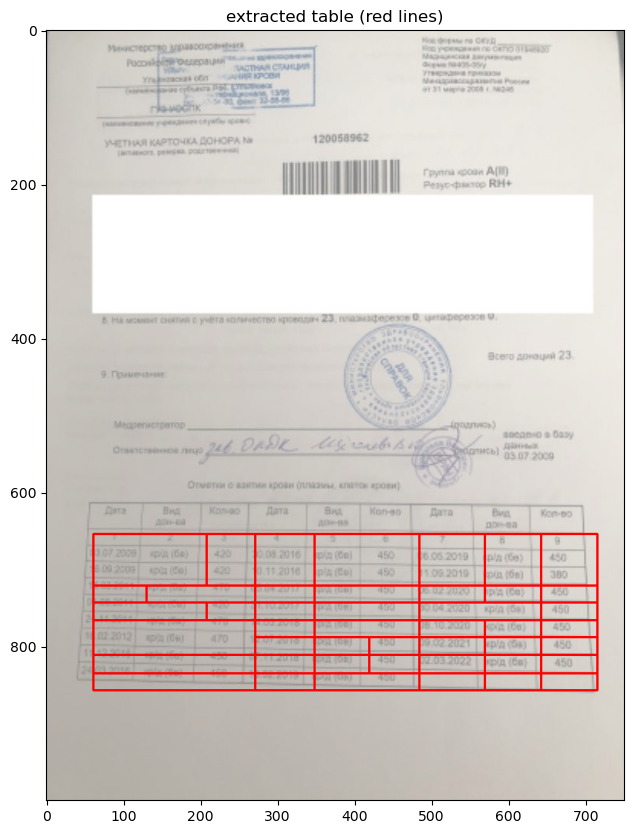

In [61]:
img_nrmlz = cv2.normalize(image, None, 0.5, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
for table in extracted_tables:
    for row in table.content.values():
        for cell in row:
            a = cv2.rectangle(img_nrmlz, (cell.bbox.x1, cell.bbox.y1), (cell.bbox.x2, cell.bbox.y2), (255, 0, 0), 2)
plt.figure(figsize=(10,10))
plt.imshow(a)
plt.title('extracted table (red lines)')
plt.show()